# ``imea`` Demo: 2D shape measurements

In this demo notebook the usage of of the open source Python package ``imea`` is demonstrated by extracting 2D shape measurements from binary images. The color images presented here are obtained by with an RGB linescan camera of the [Department of Anthropogenic Material Cycles](https://www.ants.rwth-aachen.de) at [RWTH Aachen University](https://www.rwth-aachen.de).

**Note: Please install imea using ``pip install imea`` before using this notebook.**

In [1]:
import imea

import helping_functions_demo

from pathlib import Path
from skimage import io, morphology, draw
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# better plots in matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['image.cmap'] = 'gray'

# show all columns in pandas
pd.set_option('display.max_columns', None)

## (1) Get binary image and spatial resolution
Extracting 2D shape measurements with ``imea`` is based on binary images. Binary images can be obtained from a variaty of different data sources or imaging device by segmenting objects (respresentated as ``True`` values in the binary image) from  background (respresentated as ``False`` values in the binary image). In this Section we demonstrate how to obtain binary image from RGB images by a technique called thresholding and optimzation of the segmentation result with morphological operation.

Feel free to experiment with your own images or create artificial images, e.g. with ``skimage.draw``.

### (1.1) Read RGB image
In this example we load a 2D test image from the ``imea`` repository:

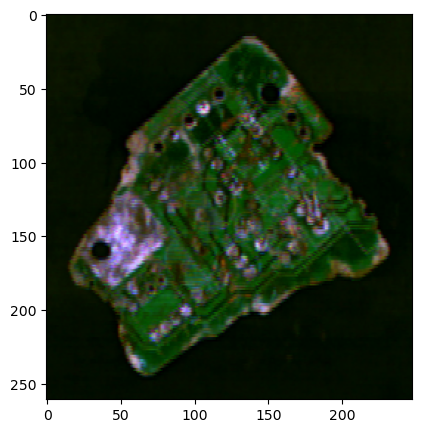

In [2]:
filename = r"weee1.png" # change here to test other images

path_example_imgs = Path(r"./example_imgs/rgb")
fullfilename = path_example_imgs / filename

img = io.imread(fullfilename)/255.

plt.imshow(img)
plt.show()

### (1.2) Segment image
Next we segment the image into foreground (object) and background, to get an binary image for ``imea`` to analyse:

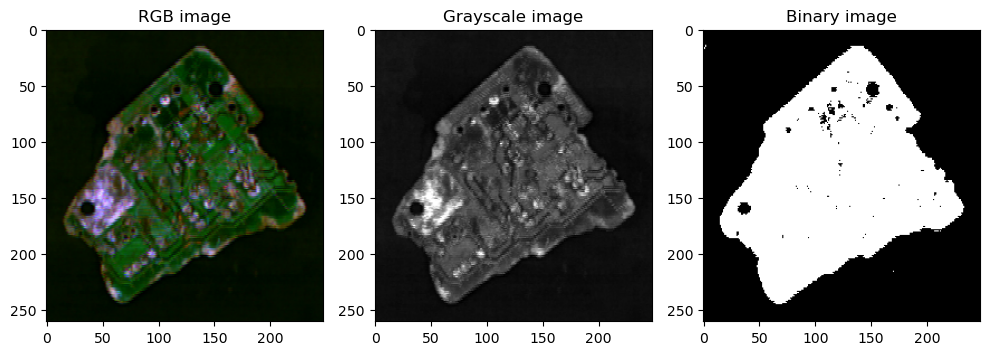

In [3]:
# transform to grayscale
img_gray = np.max(img, axis=2)

# segment with thresholding
threshold = 0.1 # you may adjust here depending on the actual image
bw_org = img_gray > threshold

# plot result
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(img)
axarr[0].set_title("RGB image")
axarr[1].imshow(img_gray)
axarr[1].set_title("Grayscale image")
axarr[2].imshow(bw_org)
axarr[2].set_title("Binary image")
plt.tight_layout()
plt.show()

### (1.3) Improve segmentation result
Now, we optimize the binary image to noise and small holes using ``skimage``:

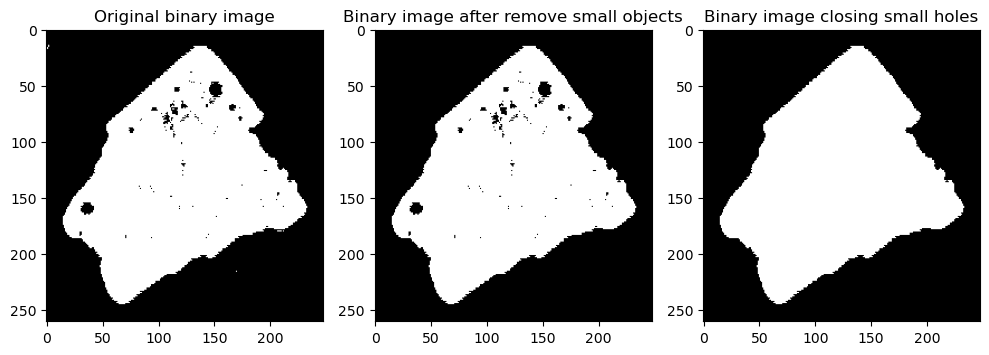

In [4]:
min_size = 300 # you may adjust here depending on the actual image
bw_smallobjects_removed = morphology.remove_small_objects(bw_org, min_size=min_size)

area_threshold = 300 # you may adjust here depending on the actual image
bw_smallholes_filled = morphology.remove_small_holes(bw_smallobjects_removed, area_threshold=area_threshold)

bw = bw_smallholes_filled

# plot result
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(bw_org)
axarr[0].set_title("Original binary image")
axarr[1].imshow(bw_smallobjects_removed)
axarr[1].set_title("Binary image after remove small objects")
axarr[2].imshow(bw_smallholes_filled)
axarr[2].set_title("Binary image closing small holes")
plt.tight_layout()
plt.show()

### (1.4) Define spatial resolution image

Every binary image in ``imea`` is expected to have a spatial resolution (given in mm/Pixel). If your image has not quadratic pixels, i.e. the spacial resolution is different in x- and y-direction, you may use ``skimage.transform.rescale()`` to rescale your image. If you want your results just in pixel, then set ``spatial_resolution_xy_mm_per_px = 1``.

In our example the spatial resolution of the test images is given as a textfile:

In [5]:
with open(Path(r"./example_imgs/rgb/spatial_resolution_xy_mm_per_px.txt"), 'r') as f:
    spatial_resolution_xy = float(f.read())
    
print("Spatial resolution is: {:0.4f} mm/Pixel".format(spatial_resolution_xy))

Spatial resolution is: 0.2861 mm/Pixel


## (2)  Extract 2D shape measurements with ``imea``
To extract all 2D shape measurements with ``imea``, we now pass our binary image (``bw``) and the spatial resolution of the image (``spatial_resolution_xy_mm_per_px``) into the function ``extract_all_shape_measurements_2d()``:

In [6]:
df = imea.shape_measurements_2d(bw, spatial_resolution_xy)

The result is a ``pandas`` dataframe:

In [7]:
df

perimeter  convex_perimeter  area_projection  area_filled  area_convex  \
0  240.568075        201.678271      2245.997491  2245.997491  2483.296847   

   major_axis_length  minor_axis_length  diameter_max_inclosing_circle  \
0          62.780509          49.028879                      41.904837   

   diameter_min_enclosing_circle  diameter_circumscribing_circle  \
0                      69.727658                       76.334804   

   diameter_inscribing_circle  diameter_equal_area  diameter_equal_perimeter  \
0                   29.351768            53.476096                 76.575196   

       x_max      y_max  width_min_bb  length_min_bb  geodeticlength  \
0  69.511323  54.922527     52.076282      59.035242       97.169912   

   thickness  n_erosions  n_erosions_complement  \
0  23.114125          84                     10   

   fractal_dimension_boxcounting_method  fractal_dimension_perimeter_method  \
0                              1.980348                            1.084637   

   feret_max  feret_min  feret_median  feret_mean  feret_mode  feret_std  \
0  69.797378  51.775924      61.35876   60.829559   62.646007  19.089984   

   martin_max  martin_min  martin_median  martin_mean  martin_mode  \
0   65.506555   43.766389      54.350417    53.620977    54.350417   

   martin_std  nassenstein_max  nassenstein_min  nassenstein_median  \
0   21.479001        69.511323         0.286055           52.634088   

   nassenstein_mean  nassenstein_mode  nassenstein_std  maxchords_max  \
0         47.127533          0.286055        63.415199      69.511323   

   maxchords_min  maxchords_median  maxchords_mean  maxchords_mode  \
0       50.34565         56.781883       57.268176       52.348033   

   maxchords_std  allchords_max  allchords_min  allchords_median  \
0      17.594317      69.511323       0.286055         30.893921   

   allchords_mean  allchords_mode  allchords_std  
0       28.106436        0.286055      73.339928

## (3) *Bonus Material:* Visualizations of 2D shape measurements
For visualization purposes the functions below illustrate the determinination of differnet circles and the minimal bounding box describing the object shape. Furthermore, different statistical length are illustrated. 

### (3.1) Circles and Minimum Bounding Box
With the function below the max inclosing, min enclosing, circumscribing and inscribing circle as well as the minimum bounding box of a region are shown. These are defined as the following:

- The *max inclosing circle* is the largest possible circle that touches the projection area from the inside.
- The *min enclosing circle* is the smallest possible circle that touches the projection area from the outside.
- The *circumscribing  circle* is the smallest possible circle, which center is the centroid of the projection area, that touches the projection area from the outside.
- The *inscribing  circle* is the largest possible circle, which center is the centroid of the projection area, that touches the projection area from the inside.
- The *minimum bounding box* is the rectangle with the smallest possible area that touches the projection area from the outside.

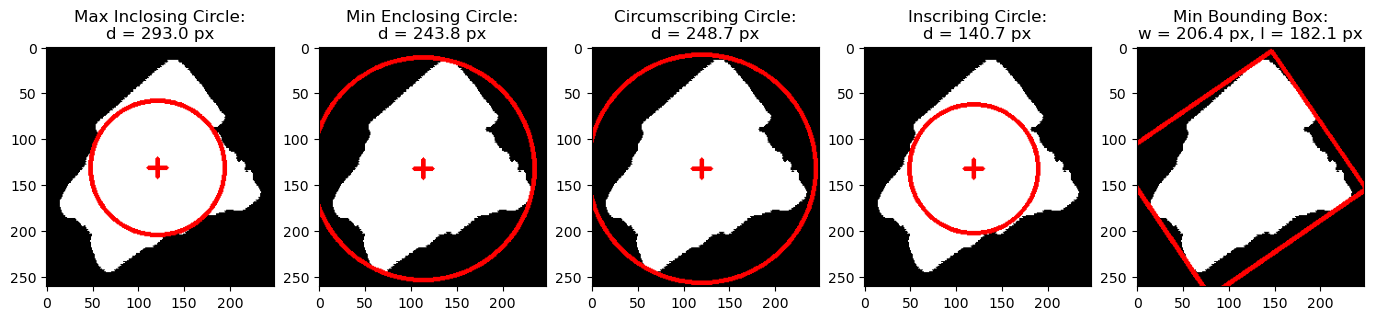

In [8]:
helping_functions_demo.visualize_circles_and_min_bb_on_bw(bw)

### (3.2) Statistical Lengths
Statistical lengths are evaluated at different rotations of an object. For each rotation a characteristic length is measured. Based on the resulting distribution (see visualization below) characteristics of the statistical length distribution (e.g. min, max, mean value) can be determined. The four presented statistical length are defined as follows:

- The *Feret diameter* is the distance between two parallel calipers orthogonal to the measurement direction (*here*: horiziontal) that touch the projection area from the outside.
- The *Martin diameter* is the length of a line in measurement direction that splits the projection area, such that 50% of the projection area is above and 50% projection area is below this line.
- The *Nassenstein diameter* is the length of a line that is orthogonal to the measurement direction, starts the lowest point of the particle and ends at the next encountered border of the projection area.
- The *maximum chord* is the longest possible line parallel to the measurement direction inside the projection area.

0 °


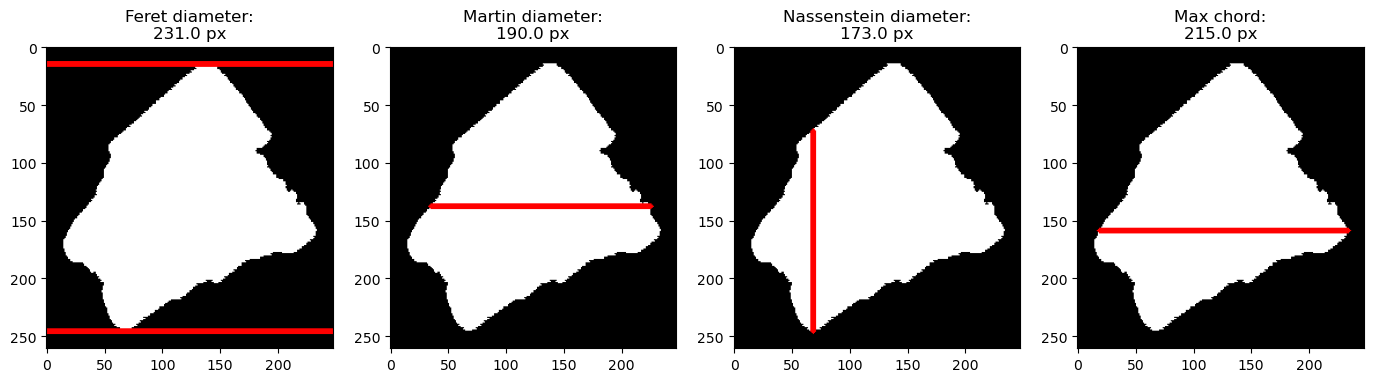

18 °


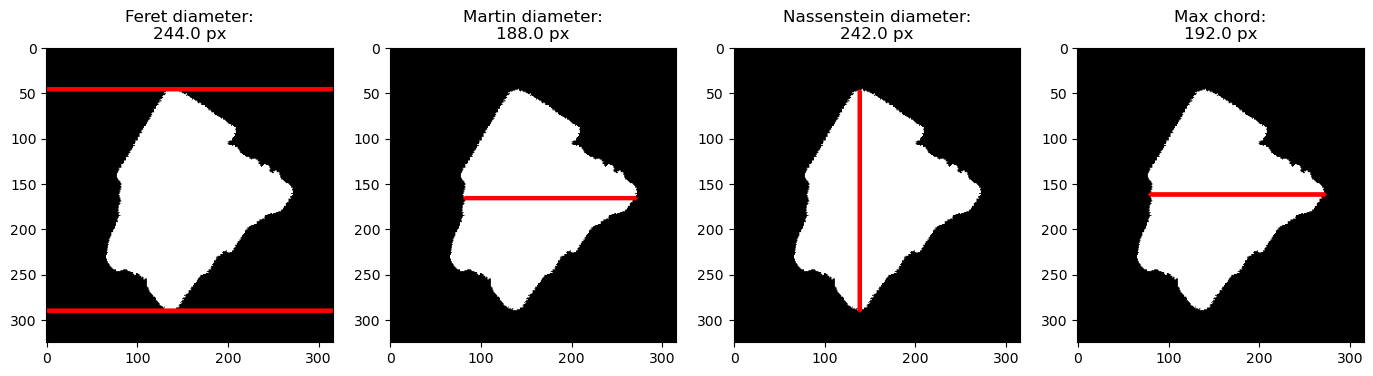

36 °


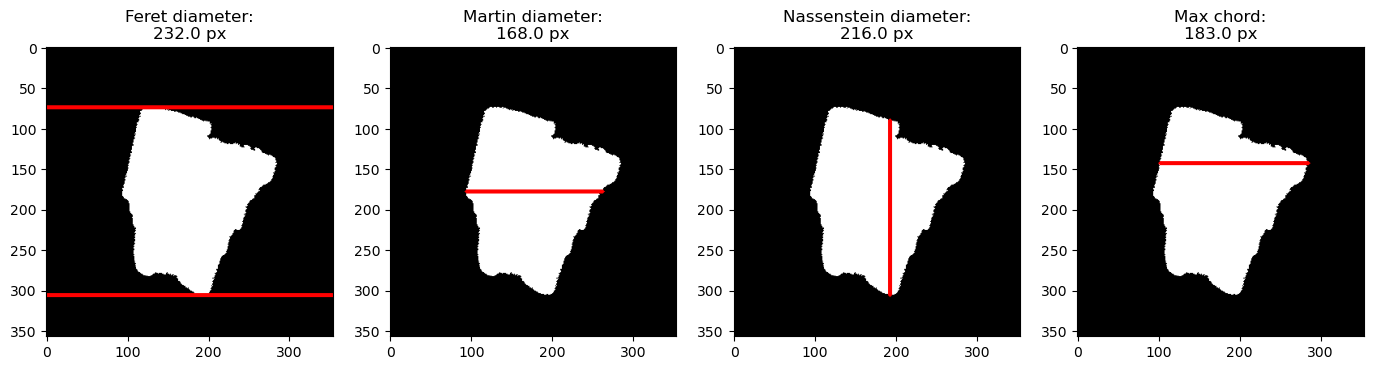

54 °


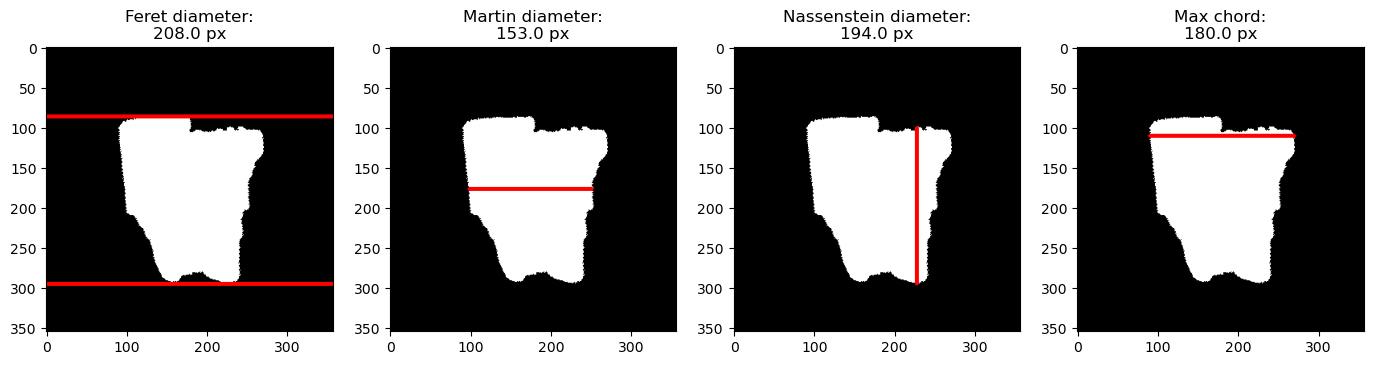

72 °


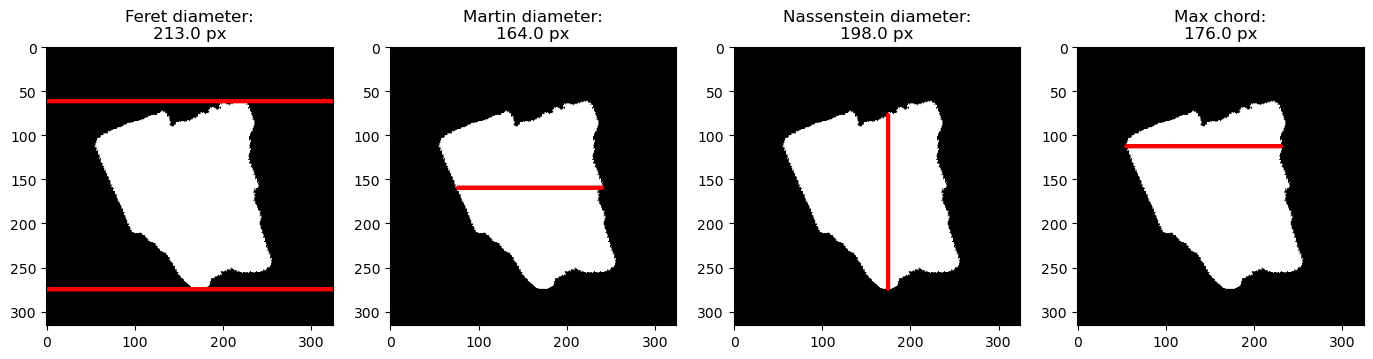

90 °


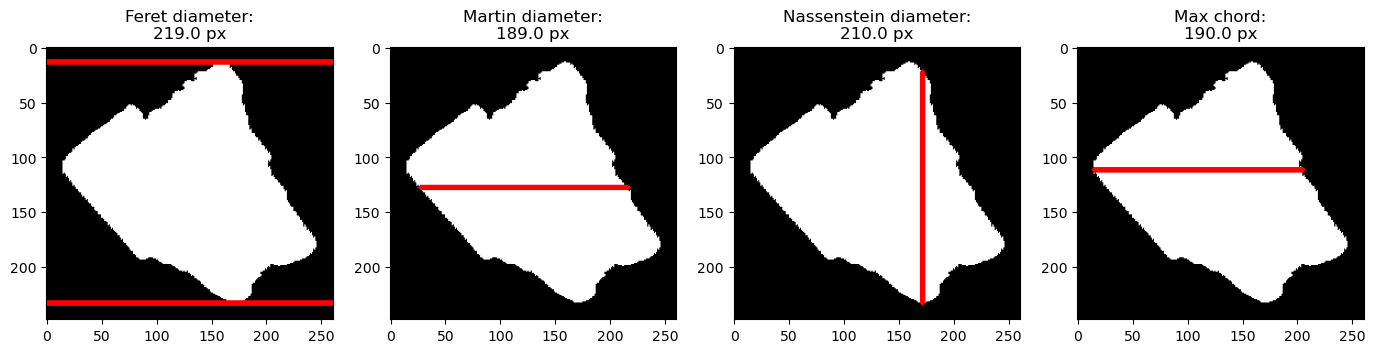

108 °


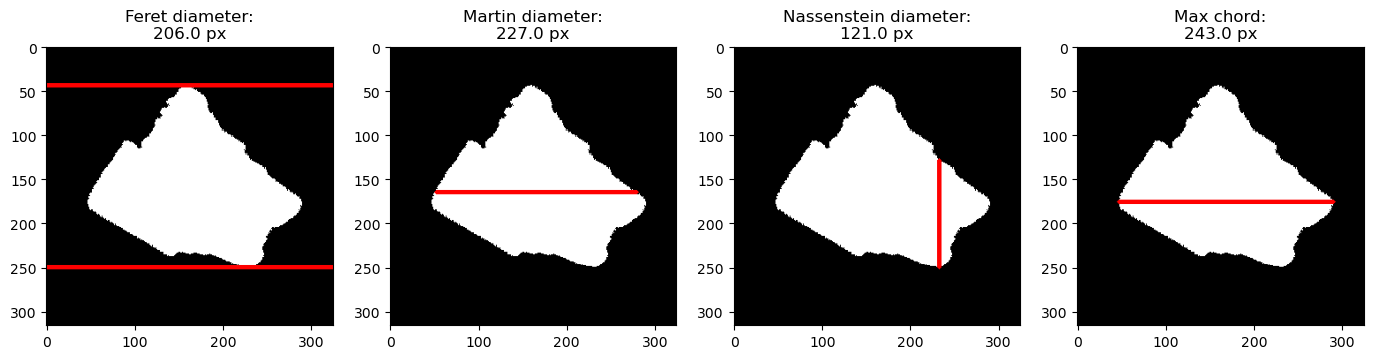

126 °


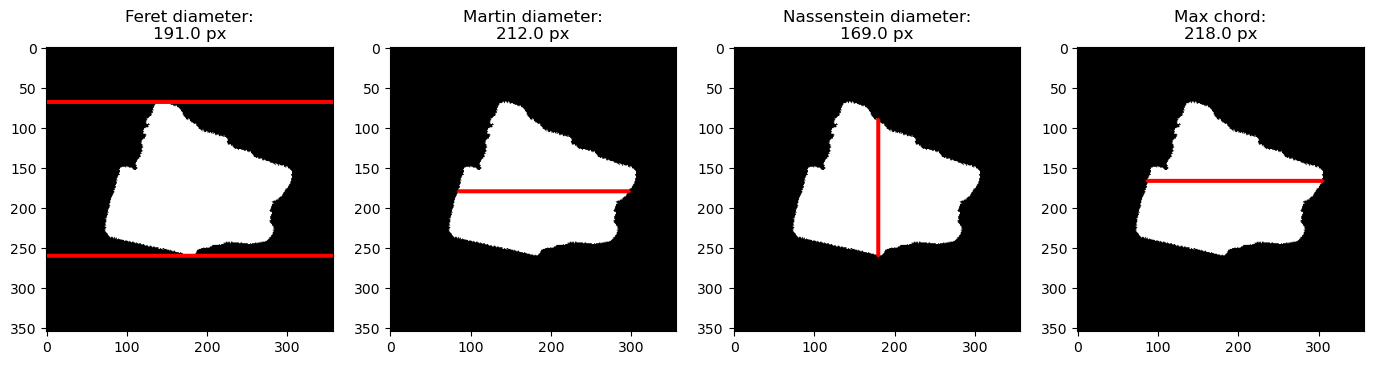

144 °


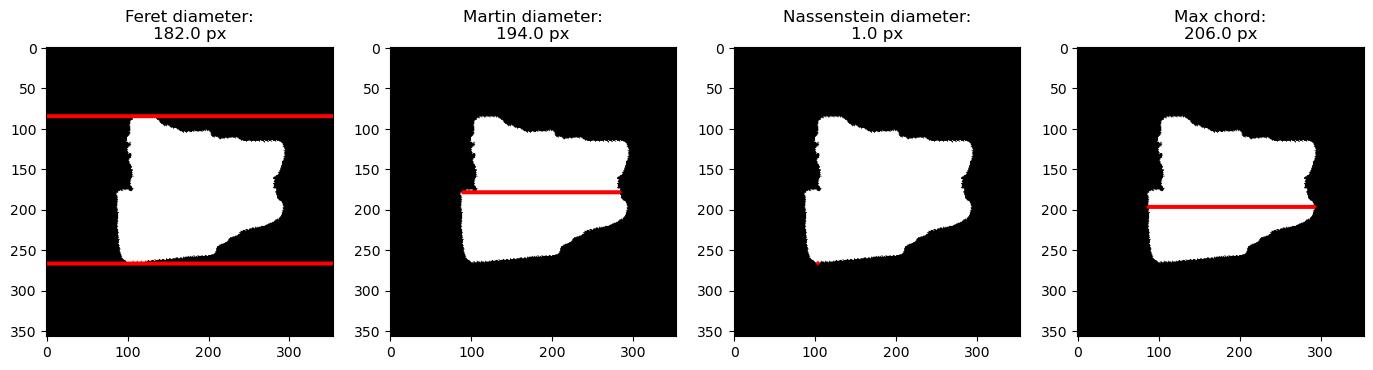

162 °


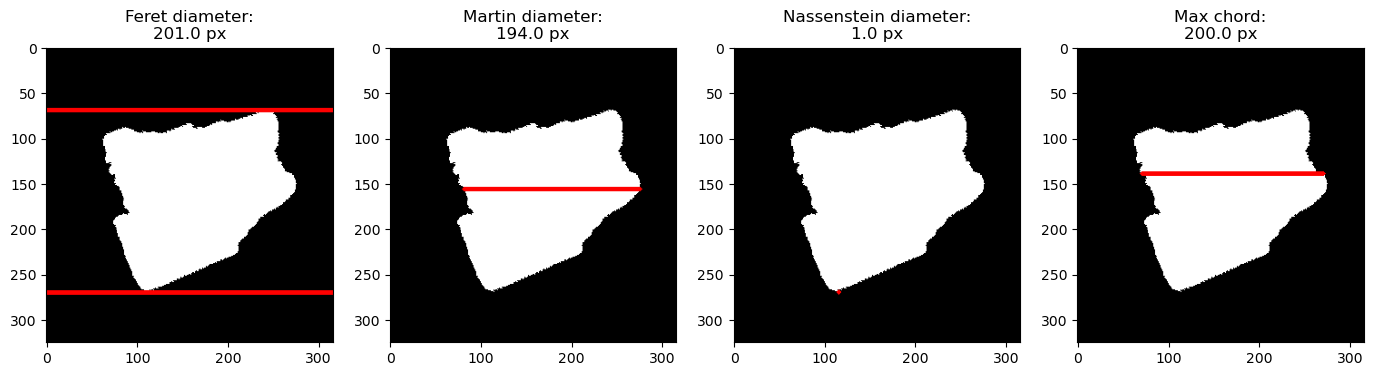

In [9]:
daplha = 18 # stepsize of angle to rotate object shape in iteration, in degrees (°)
angles = np.arange(0,180,daplha)

for angle in angles:
    print("{:0.0f} °".format(angle))
    helping_functions_demo.visualize_statistical_length_on_bw(bw, angle)

### (3.3) Distribution Statistical Lengths
Based on the measurements at different angles a distribution and the resulting characteristics (min, max, mean, ...) can be determined:

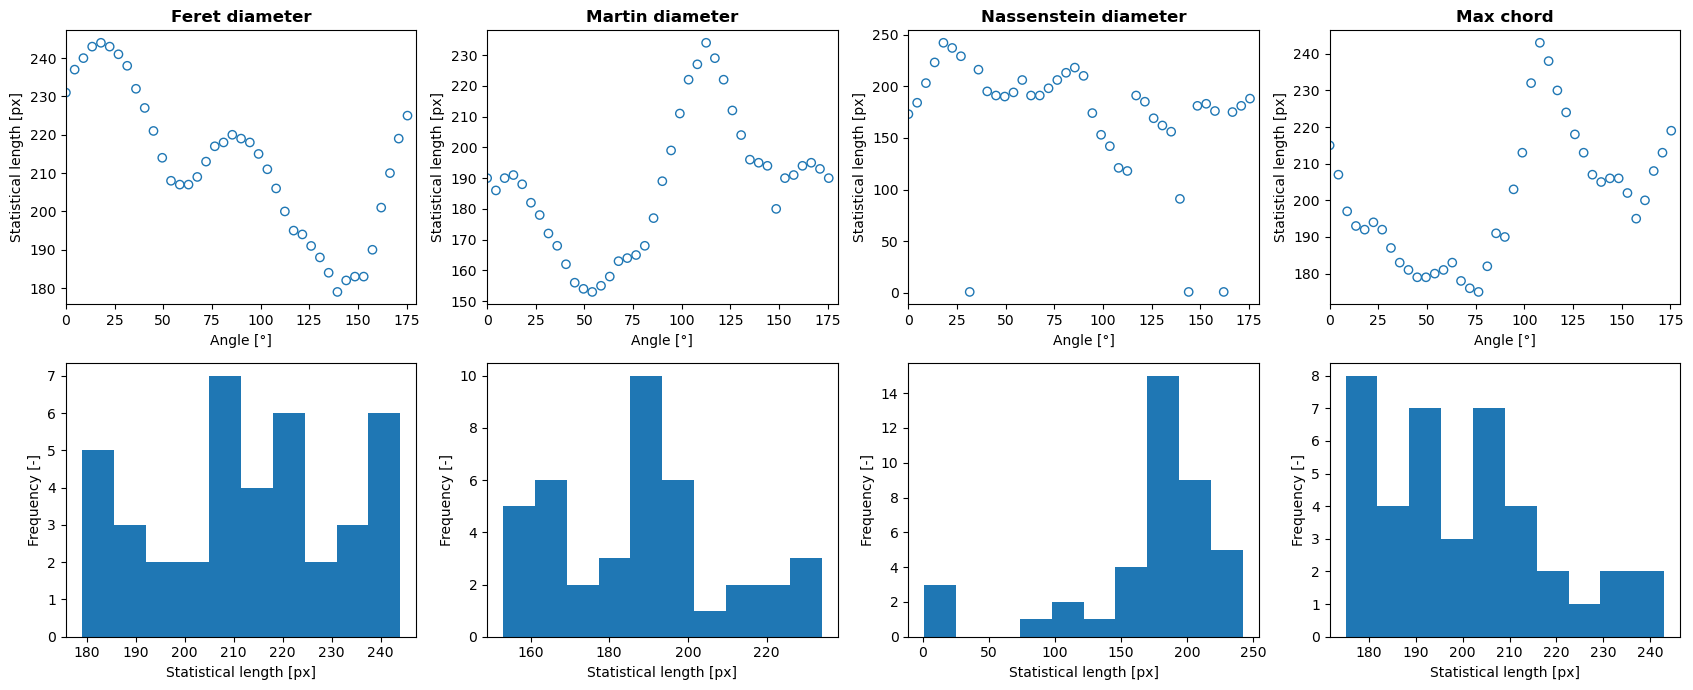

In [10]:
helping_functions_demo.plot_statistical_lenghts_distributions(bw, 4.5)